# Bayesian Inference Exercise: Enhancing a Medical Diagnosis System (UCI Heart Disease)

This notebook implements a Bayesian logistic regression model using **PyMC** on the UCI Cleveland Heart Disease dataset.

**Outputs:** posterior probabilities of disease, ROC/AUC, confusion matrix, and posterior plots.

Author: Marisa Tania

## 1) Data loading and preprocessing

The dataset looks like the classic UCI heart disease data. We will work with the processed Cleveland data, which has 303 rows and 14 columns. The target values range from 0 to 4, so we will simplify it and make it binary: presence of disease if the target is greater than 0. Let's go ahead and load the data.

- Load `processed.cleveland.data`
- Replace '?' with NaN
- Binarize target: `disease = 1` if target ∈ {1,2,3,4}, else `0`
- Impute missing values
- One-hot encode categoricals and standardize features


In [19]:
import os, zipfile, shutil
import numpy as np
import pandas as pd

zip_path = "/mnt/data/Assignment_3_DataSet_heart+disease (1).zip"
work_dir = "/mnt/data/bayes_heart_artifacts"
extract_dir = os.path.join(work_dir, "data")
os.makedirs(work_dir, exist_ok=True)
shutil.rmtree(extract_dir, ignore_errors=True)
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_dir)

In [20]:
data_path = os.path.join(extract_dir, "processed.cleveland.data")
cols = ["age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","target"]
df = pd.read_csv(data_path, header=None, names=cols)

df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB


In [24]:
(df == "?").any()

,0
age,False
sex,False
cp,False
trestbps,False
chol,False
fbs,False
restecg,False
thalach,False
exang,False
oldpeak,False


### Handling missing values in dataset
Looks like the dataset has missing values marked as '?'. These might be in the 'ca' and 'thal' columns. We will need to detect these '?' values and replace them with NaN and cast values to floats, then impute.

For numerical columns, we will use the median, and for categorical ones, the mode. we will treat certain columns as categorical, like 'cp', 'restecg', and 'thal', and binary for 'sex', 'fbs', and 'exang', applying one-hot encoding as needed.

For modeling, we will use Bayesian logistic regression, defining priors based on disease prevalence—starting with a prior of around 0.35 for coronary heart disease, adjusting for clinic setting.

In [ ]:
df = df.replace("?", np.nan)
for c in cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df["disease"] = (df["target"] > 0).astype(int)

cat_cols = ["cp","restecg","slope","thal"]
bin_cols = ["sex","fbs","exang"]
num_cols = ["age","trestbps","chol","thalach","oldpeak","ca"]

for c in num_cols:
    df[c] = df[c].fillna(df[c].median())
for c in cat_cols + bin_cols:
    df[c] = df[c].fillna(df[c].mode().iloc[0])

X = pd.get_dummies(df[cat_cols+bin_cols+num_cols], columns=cat_cols, drop_first=True)
y = df["disease"].values

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X.values, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train).astype("float32")
X_test_s  = scaler.transform(X_test).astype("float32")

feature_names = X.columns.tolist()

df.head(), df.shape, y.mean()


(    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
 0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
 1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
 2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
 3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
 4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   
 
    slope   ca  thal  target  disease  
 0    3.0  0.0   6.0       0        0  
 1    2.0  3.0   3.0       2        1  
 2    2.0  2.0   7.0       1        1  
 3    3.0  0.0   3.0       0        0  
 4    1.0  0.0   3.0       0        0  ,
 (303, 15),
 np.float64(0.45874587458745875))

## 2) Prior knowledge (baseline risk)
We encode external knowledge as a prior on the intercept (baseline log-odds). If `p0` is the baseline probability of disease before features, then:

$$\alpha \sim \mathcal{N}(\mathrm{logit}(p_0), \sigma_\alpha)$$

In this notebook we use **p0 = 0.25** and **σ = 1.0** to reflect moderate uncertainty while acknowledging that diagnostic cohorts have higher risk than the general population.


## 3) Bayesian logistic regression in PyMC
Note: this environment disables Aesara C compilation (no `Python.h`), so we switch Aesara to `FAST_COMPILE`.


In [4]:
!pip install pymc>=5 arviz
import pymc as pm
import pytensor
print(pm.__version__)
print(pytensor.__version__)

5.27.0
2.36.3


In [5]:
import math
import pymc as pm
import pytensor.tensor as pt  # PyMC v5 backend

p0 = 0.25
mu_alpha = math.log(p0/(1 - p0))   # logit(p0)
sigma_alpha = 1.0

with pm.Model() as model:
    alpha = pm.Normal("alpha", mu=mu_alpha, sigma=sigma_alpha)
    beta  = pm.Normal("beta",  mu=0.0, sigma=1.0, shape=X_train_s.shape[1])

    logits = alpha + pt.dot(X_train_s, beta)

    pm.Bernoulli("obs", logit_p=logits, observed=y_train)

    idata = pm.sample(
        draws=500,
        tune=500,
        chains=2,
        target_accept=0.9,
        random_seed=42
    )

idata

Output()

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [15]:
import arviz as az


print("=== Stage 1 Posterior Diagnostics ===")
az.summary(
idata_stage1,
var_names=["alpha", "beta"],
round_to=3
)

=== Stage 1 Posterior Diagnostics ===


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.132,0.287,-0.662,0.409,0.010,0.015,800.928,278.509,1.002
beta[0],1.036,0.328,0.407,1.625,0.013,0.010,675.477,528.782,1.004
beta[1],0.012,0.291,-0.480,0.569,0.009,0.013,1088.464,471.144,0.998
beta[2],0.253,0.284,-0.305,0.754,0.010,0.010,732.455,553.479,1.009
beta[3],-0.025,0.321,-0.613,0.574,0.011,0.011,823.350,545.669,1.005
beta[4],0.320,0.288,-0.242,0.822,0.010,0.011,805.636,514.817,1.005
beta[5],0.376,0.285,-0.092,0.932,0.008,0.010,1264.029,578.175,0.999
beta[6],-0.313,0.404,-1.021,0.471,0.014,0.016,784.180,460.908,1.004
beta[7],0.559,0.427,-0.213,1.403,0.020,0.018,458.426,423.041,0.999
beta[8],1.328,0.378,0.661,2.064,0.014,0.013,771.604,547.867,1.002


## 4) Posterior predictive probabilities and evaluation
We compute test-set probabilities by averaging $\sigma(\alpha + x^T\beta)$ across posterior draws.


In [7]:
import numpy as np
from sklearn.metrics import (
accuracy_score,
log_loss,
confusion_matrix,
roc_auc_score
)

# Posterior samples
posterior = idata.posterior
alpha_s = posterior["alpha"].values.reshape(-1)
beta_s = posterior["beta"].values.reshape(-1, X_train_s.shape[1])


# Posterior predictive probabilities
logits_s = alpha_s[:, None] + beta_s @ X_test_s.T
p_s = 1 / (1 + np.exp(-logits_s))
p_mean = p_s.mean(axis=0)


# Class predictions (threshold = 0.5)
y_pred = (p_mean >= 0.5).astype(int)


# Metrics
acc = accuracy_score(y_test, y_pred)
ll = log_loss(y_test, p_mean)
cm = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, p_mean)


# Pretty output
print("=== Bayesian Model Evaluation (Test Set) ===")
print(f"Accuracy : {acc:.3f}")
print(f"Log Loss : {ll:.3f}")
print(f"ROC AUC : {auc:.3f}")
print("\nConfusion Matrix [ [TN, FP], [FN, TP] ]:")
print(cm)


=== Bayesian Model Evaluation (Test Set) ===
Accuracy : 0.803
Log Loss : 0.355
ROC AUC : 0.921

Confusion Matrix [ [TN, FP], [FN, TP] ]:
[[27  6]
 [ 6 22]]


### ROC Curve and Confusion Matrix

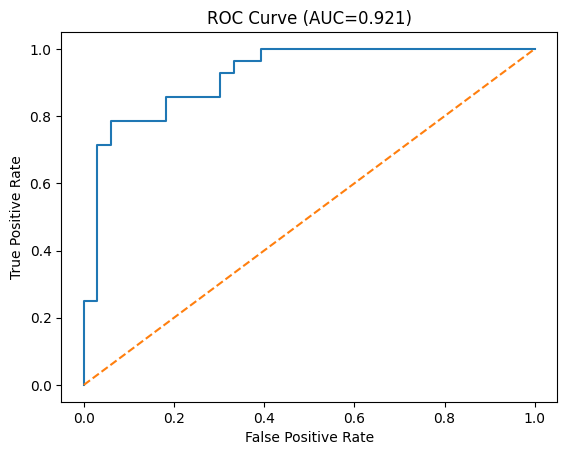

<Figure size 640x480 with 0 Axes>

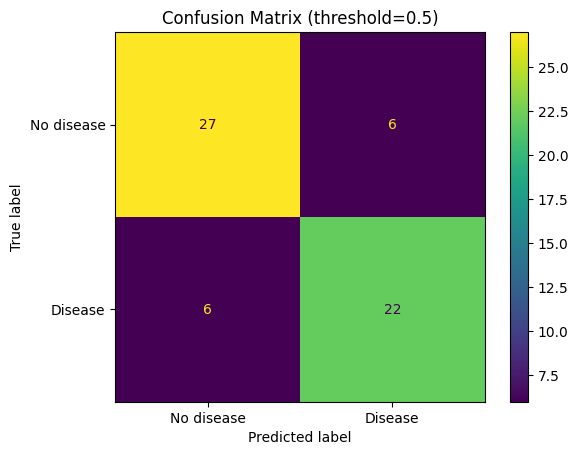

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fpr, tpr, thr = roc_curve(y_test, p_mean)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC={auc:.3f})")
plt.show()

plt.figure()
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No disease","Disease"]).plot()
plt.title("Confusion Matrix (threshold=0.5)")
plt.show()


## 5) Posterior inspection
Below we visualize the intercept posterior and the top coefficients by absolute posterior mean.


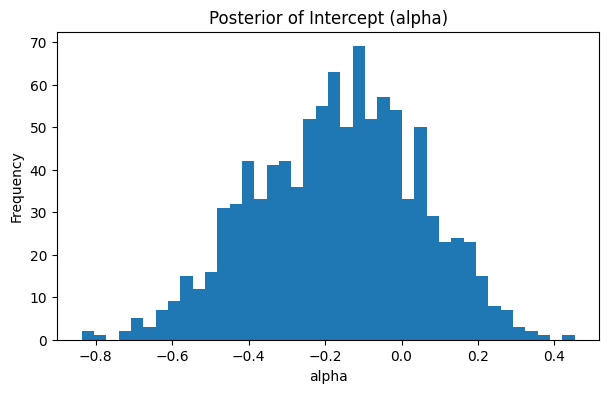

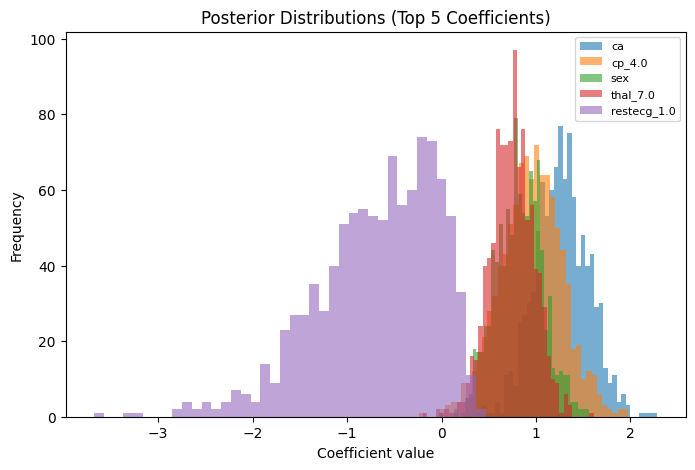

['ca', 'cp_4.0', 'sex', 'thal_7.0', 'restecg_1.0']

In [9]:
import numpy as np
import matplotlib.pyplot as plt

alpha_samples = posterior["alpha"].values.reshape(-1)
beta_samples  = posterior["beta"].values.reshape(-1, len(feature_names))
beta_mean = beta_samples.mean(axis=0)

top_idx = np.argsort(np.abs(beta_mean))[::-1][:5]
top_features = [feature_names[i] for i in top_idx]

plt.figure(figsize=(7,4))
plt.hist(alpha_samples, bins=40)
plt.title("Posterior of Intercept (alpha)")
plt.xlabel("alpha")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8,5))
for idx, name in zip(top_idx, top_features):
    plt.hist(beta_samples[:, idx], bins=40, alpha=0.6, label=name)
plt.title("Posterior Distributions (Top 5 Coefficients)")
plt.xlabel("Coefficient value")
plt.ylabel("Frequency")
plt.legend(fontsize=8)
plt.show()

top_features


## 6) Dynamic updating demo (two-stage)
One simple way to illustrate Bayesian updating is:
1) fit on an initial batch, then
2) use the *posterior* (approximated as Normal via mean/std) as the *prior* for the next batch.

This mimics online learning and is easy to implement for logistic regression.


In [11]:
import numpy as np
import pymc as pm
import pytensor.tensor as pt

# Split training data into two sequential batches
n = X_train_s.shape[0]
cut = int(0.7 * n)

X_a, y_a = X_train_s[:cut], y_train[:cut]
X_b, y_b = X_train_s[cut:], y_train[cut:]

In [12]:
# --------------------------------------------------
# Stage 1: Initial Bayesian fit
# --------------------------------------------------
with pm.Model() as stage1_model:
    alpha_1 = pm.Normal("alpha", mu=mu_alpha, sigma=sigma_alpha)
    beta_1  = pm.Normal("beta", mu=0.0, sigma=1.0, shape=X_a.shape[1])

    logits_1 = alpha_1 + pt.dot(X_a, beta_1)
    pm.Bernoulli("obs", logit_p=logits_1, observed=y_a)

    idata_stage1 = pm.sample(
        draws=300,
        tune=300,
        chains=2,
        target_accept=0.9,
        random_seed=42
    )

# Extract posterior summaries
alpha_post = idata_stage1.posterior["alpha"].values.reshape(-1)
beta_post  = idata_stage1.posterior["beta"].values.reshape(-1, X_a.shape[1])

alpha_mu = float(alpha_post.mean())
alpha_sd = float(alpha_post.std() + 1e-6)

beta_mu = beta_post.mean(axis=0)
beta_sd = beta_post.std(axis=0) + 1e-6

# --------------------------------------------------
# Stage 2: Posterior-as-prior update
# --------------------------------------------------
with pm.Model() as stage2_model:
    alpha_2 = pm.Normal("alpha", mu=alpha_mu, sigma=alpha_sd)
    beta_2  = pm.Normal("beta", mu=beta_mu, sigma=beta_sd, shape=X_b.shape[1])

    logits_2 = alpha_2 + pt.dot(X_b, beta_2)
    pm.Bernoulli("obs", logit_p=logits_2, observed=y_b)

    idata_stage2 = pm.sample(
        draws=300,
        tune=300,
        chains=2,
        target_accept=0.9,
        random_seed=42
    )


Output()

Output()

In [14]:
idata_stage2

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [16]:
print("=== Stage 2 Posterior Diagnostics ===")
az.summary(
idata_stage2,
var_names=["alpha", "beta"],
round_to=3
)

=== Stage 2 Posterior Diagnostics ===


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.140,0.219,-0.531,0.285,0.008,0.009,708.404,432.812,1.002
beta[0],1.003,0.277,0.537,1.540,0.010,0.010,772.868,496.007,1.000
beta[1],-0.032,0.239,-0.446,0.419,0.009,0.009,654.967,445.694,1.001
beta[2],0.263,0.249,-0.165,0.735,0.009,0.010,825.564,373.795,0.999
beta[3],0.073,0.252,-0.414,0.530,0.010,0.009,620.761,515.956,1.012
beta[4],0.555,0.248,0.041,0.996,0.008,0.010,878.781,382.377,1.001
beta[5],0.284,0.242,-0.203,0.721,0.008,0.009,819.841,544.752,1.001
beta[6],-0.497,0.302,-0.992,0.098,0.013,0.011,557.963,435.402,1.004
beta[7],0.412,0.325,-0.236,1.027,0.012,0.013,802.365,437.345,1.002
beta[8],1.160,0.260,0.723,1.668,0.009,0.008,842.389,509.305,1.001


In [13]:
alpha2_samples = idata_stage2.posterior["alpha"].values.reshape(-1)


print("=== Sequential Bayesian Update Summary ===")
print(f"Stage 1 α mean (prior → posterior): {alpha_mu:.3f}")
print(f"Stage 1 α std : {alpha_sd:.3f}")
print("-" * 45)
print(f"Stage 2 α mean (updated posterior): {alpha2_samples.mean():.3f}")
print(f"Stage 2 α std : {alpha2_samples.std():.3f}")

=== Sequential Bayesian Update Summary ===
Stage 1 α mean (prior → posterior): -0.132
Stage 1 α std : 0.287
---------------------------------------------
Stage 2 α mean (updated posterior): -0.140
Stage 2 α std : 0.219


array([<Axes: title={'center': 'Stage 1 α'}>,
       <Axes: title={'center': 'Stage 2 α'}>], dtype=object)

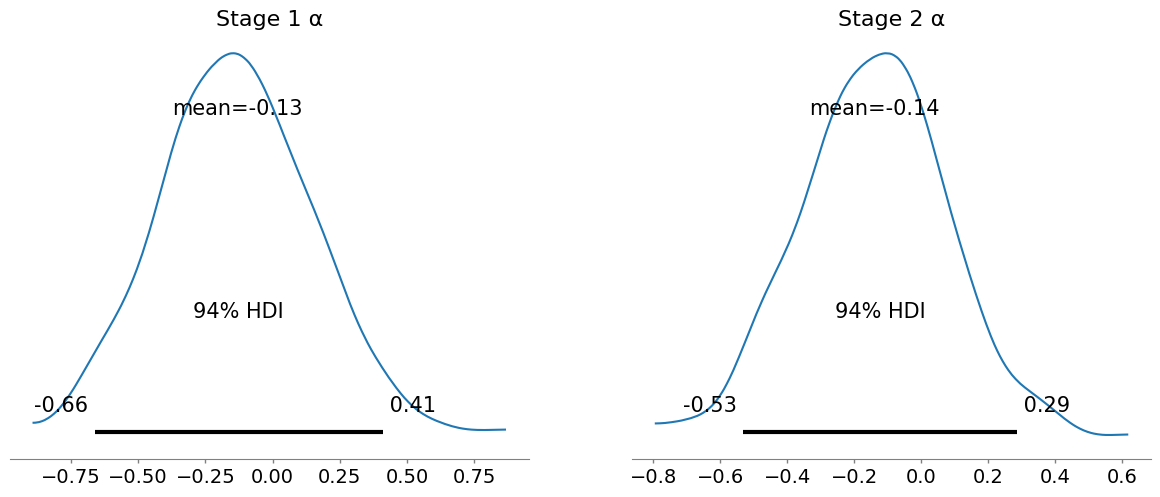

In [17]:
az.plot_posterior(
{
"Stage 1 α": idata_stage1.posterior["alpha"],
"Stage 2 α": idata_stage2.posterior["alpha"],
},
hdi_prob=0.94
)

In [18]:
summary = pd.DataFrame({
"Stage": ["Stage 1", "Stage 2"],
"Alpha Mean": [
idata_stage1.posterior["alpha"].values.mean(),
idata_stage2.posterior["alpha"].values.mean(),
],
"Alpha Std": [
idata_stage1.posterior["alpha"].values.std(),
idata_stage2.posterior["alpha"].values.std(),
],
})


summary.round(3)

,Stage,Alpha Mean,Alpha Std
0,Stage 1,-0.132,0.287
1,Stage 2,-0.140,0.219
